In [558]:
import sys
import os
import numpy as np
import tensorflow 
import keras
from keras.models import model_from_json, load_model
import pandas as pd
import logomaker as lm
import matplotlib.pyplot as plt 

In [559]:
gpu = 1 # don't set this to 0 

if gpu > -1:
	device = '/gpu:%i' % gpu
	os.environ['CUDA_VISIBLE_DEVICES']=str(1)
else:
	device = '/cpu:0'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [560]:
# loading model 1
model_file_1 = "/isdata/alab/people/masa/deep_learning_21_student/GM12878_rDHS_finetuned/partition_1/model_compiled.h5"
model_1 = load_model(model_file_1, compile=False)

### Loading data

In [846]:
df = pd.read_csv('/isdata/alab/people/masa/deep_learning_21_student/GM12878_rDHS_finetuned/dataset_GM12878_600.csv', sep='\t')

In [847]:
df.head()

,Region,Sequence,zscore,cell_line,Chr,Fold,Len
0,chr1:112466510-112467110,GCGGAACGAAGCCTAGACTGCGTAAAAAaaaacagagaacagaaac...,3.78050,GM12878,chr1,0,600.0
1,chr1:156122722-156123322,CAGAACTGTTACCTTAGAGCTGGCCAGGATTAGAGAACAGTGCCTG...,2.39238,GM12878,chr1,0,600.0
2,chr14:20663708-20664308,GCTGCAGGGTCTGCTGAAAGTCCTTAAGCAGCCCTTTCCTAAAACT...,1.97273,GM12878,chr14,0,600.0
3,chr19:18410476-18411076,AAAATATGGACAAACAAGAAAAAAAGATGCGCAGGGAGGAGTTCAA...,2.24890,GM12878,chr19,0,600.0
4,chr1:778437-779037,cggccGCGCCAGACATAGTTTTCTATTTTTGACCAACATAAACACT...,3.73188,GM12878,chr1,0,600.0


In [848]:
df.cell_line.value_counts()

# GM12878 corresponds to the positive class
# GM12878_NEG and Negative corresponds to the negative class

GM12878        105655
GM12878_NEG     89684
Negative        21079
Name: cell_line, dtype: int64

In [540]:
df.Fold.value_counts()

# there are 28899 sequences where the Fold is wrongly 600 (there was no value so when the file was read,
# the value in len was read into Fold)

0      70583
2      61275
1      55661
600    28899
Name: Fold, dtype: int64

### Loading importance scores

The importance scores are contained in an HDF5 file. HDF5 files are organized in a hierarchical structure, with two primary structures: groups and datasets.

 - HDF5 group: a grouping structure containing instances of zero or more groups or datasets, together with supporting metadata.
 - HDF5 dataset: a multidimensional array of data elements, together with supporting metadata.

In [464]:
import h5py

In [465]:
f = h5py.File('/isdata/alab/people/masa/deep_learning_21_student/GM12878_rDHS_finetuned/shap_score_1.h5','r')

In [466]:
list(f.keys())

# this HDF5 file contains two groups. The importance scores are in the group 'contrib_scores'

['contrib_scores', 'hyp_contrib_scores']

In [467]:
contrib_scores = f['contrib_scores']
for name in contrib_scores:
    print (name)
    
# the group 'contrib_scores' contains a dataset called task0

task0


In [671]:
contrib_scores['task0']

# for each position in each sequence there are 4 importance scores, due to the nature of the encoding. 
# One corresponds to the actual base-pair in that position and the other 3 to the potential score of the other base-pairs.

<HDF5 dataset "task0": shape (105655, 600, 4), type "<f8">

In [415]:
df.cell_line.value_counts()
# there are as many positives as importance scores in shap_score_1.h5

GM12878        105655
GM12878_NEG     89684
Negative        21079
Name: cell_line, dtype: int64

In [725]:
df.loc[((df.Fold == 0) | (df.Fold == 2)) & (df.cell_line == 'GM12878')].Fold[0:1000].value_counts()

# the first 1000 sequences are from partition 0, so if I work with these sequences the order is mantained and I can do 
# pairwise comparison with the importance scores

0    1000
Name: Fold, dtype: int64

In [541]:
# For the following analyses, only positive sequences belonging to partitions (Fold) 0 or 2 will be used,
# since I am using the model that was trained on partition 1 

sequences = df.loc[((df2.Fold == 0) | (df2.Fold == 2)) & (df2.cell_line == 'GM12878')].Sequence.str.upper()
len(sequences)

67198

### Functions

In [561]:
encoder = np.identity(4)
encoder_dict = dict()
for i, letter in enumerate ('ACGT'):
    encoder_dict[letter] = encoder[i]

def one_hot_encoder (seq, encoder_dict):
    """one hot encodes the sequences and returns them in right shape for the model"""
    encoded_seq = np.zeros((len(seq), len(encoder_dict)))
    for i, letter in enumerate (seq):
        encoded_seq[i] = encoder_dict[letter]
    return encoded_seq  

In [687]:
def random_mutagenesis_1seq (seq):
    """given a sequence calculates the initial prediction, mutates each position at random,
    gets new prediction and calculates delta score. Returns a pd series containing the delta scores
    for each position mutated at random and the initial prediction"""
    
    delta_scores = list()
    init_encoded_seq = np.array([one_hot_encoder(seq, encoder_dict)])
    initial_pred = model_1.predict(init_encoded_seq, batch_size=1)

    for i in range (len(seq)):

        new_seq = list(seq)

        if new_seq[i] == 'A': 
            new_seq[i] = random.choice('CGT')
        elif new_seq[i] == 'C':
            new_seq[i] = random.choice('AGT')
        elif new_seq[i] == 'G':
            new_seq[i] = random.choice('ACT')
        else:
            new_seq[i] = random.choice('ACG')

        new_seq = ''.join(new_seq)
        encoded_seq = np.array([one_hot_encoder(new_seq, encoder_dict)])
        new_pred = model_1.predict(encoded_seq, batch_size = 1)
        delta_scores.append(new_pred[0][0] - initial_pred[0][0])

    return pd.Series(delta_scores), initial_pred[0][0]

In [563]:
def controlled_mutagenesis_1seq (seq): 
    """given a sequence calculates the initial prediction, mutates each position to each other possible nucleotide,
    gets new prediction and calculates delta score. Returns a pd series containing the delta scores
    for each possible nucleotide change at each position"""
    delta_scores = dict()
    init_encoded_seq = np.array([one_hot_encoder(seq, encoder_dict)])
    initial_pred = model_1.predict(init_encoded_seq, batch_size = 1)
    
    for i in range (len(seq)):
        
        for letter in ('ACGT'): 

            if letter in delta_scores:
                new_seq = list(seq)
                new_seq[i] = letter
                new_seq = ''.join(new_seq)
                encoded_seq = np.array([one_hot_encoder(new_seq, encoder_dict)])
                new_pred = model_1.predict(encoded_seq, batch_size = 1)
                delta_scores[letter].append(new_pred[0][0] - initial_pred[0][0])

            if letter not in delta_scores:
                new_seq = list(seq)
                new_seq[i] = letter
                new_seq = ''.join(new_seq)
                encoded_seq = np.array([one_hot_encoder(new_seq, encoder_dict)])
                new_pred = model_1.predict(encoded_seq, batch_size = 1)
                delta_scores[letter] = [new_pred[0][0] - initial_pred[0][0]]
    
    return pd.DataFrame(delta_scores)

In [564]:
def controlled_mutagenesis_avg (sequences, n):
    # Calculates average delta score after susbstituting each position with each possible residue over n sequences
    delta_scores = dict()

    for j in range (len(sequences[0:n])):

        seq = df.Sequence[j].upper()
        init_encoded_seq = np.array([one_hot_encoder(seq, encoder_dict)])
        initial_pred = model_1.predict(init_encoded_seq, batch_size = 1)
        
        for i in range (len(seq)):
            
            if j == 0:
                
                for letter in 'ACGT':
                   
                    if letter in delta_scores:
                        new_seq = list(seq)
                        new_seq[i] = letter
                        new_seq = ''.join(new_seq)
                        encoded_seq = np.array([one_hot_encoder(new_seq, encoder_dict)])
                        new_pred = model_1.predict(encoded_seq, batch_size = 1)
                        delta_scores[letter].append(new_pred[0][0] - initial_pred[0][0])
                    if letter not in delta_scores:
                        new_seq = list(seq)
                        new_seq[i] = letter
                        new_seq = ''.join(new_seq)
                        encoded_seq = np.array([one_hot_encoder(new_seq, encoder_dict)])
                        new_pred = model_1.predict(encoded_seq, batch_size = 1)
                        delta_scores[letter] = [new_pred[0][0] - initial_pred[0][0]]
                        
            else:

                new_seq_list = list(seq)

                for letter in 'ACGT': 

                    new_seq_list[i] = letter
                    new_seq = ''.join(new_seq_list)
                    encoded_seq = np.array([one_hot_encoder(new_seq, encoder_dict)])
                    new_pred = model_1.predict(encoded_seq, batch_size = 1)
                    delta_scores[letter][i] += new_pred[0][0] - initial_pred[0][0]
               
    df_delta = pd.DataFrame(delta_scores)/n
    
    return df_delta 

In [ ]:
def importance_scores_1seq(seq, pos):
    """extracts the importance score that corresponds to the nucleotide that is present
    in each position of the sequence from the HDF5 file"""
    imp_scores = list()

    for i in range(len(seq)):
        j=0
        for letter in 'ACGT':
            j += 1
            if seq[i] == letter:
                imp_scores.append(contrib_scores['task0'][pos][i][j-1])
                break
                
    return pd.Series(imp_scores)
            

In [698]:
def corr_vs_pred (sequences, n_seq, n_pos):
    """given a series of sequences it calculates the correlation between delta scores and importance score
    for n_seq sequences for the n_pos top positions with a highest importance score. returns a dataframe 
    containing the correlations, the initial prediction for each sequence and its index in the initial series"""
    initial_preds = list()
    correlations = list()
    seq_number = list()

    for i in range(n_seq):

        # getting the delta scores and initial prediction for each sequence
        seq = sequences[i]
        delta_scores, initial_pred = random_mutagenesis_pred(seq)

        # getting the max importance score for each sequence 
        importance_scores = importance_scores_1seq (seq, i)

        df_temp = pd.DataFrame()
        df_temp['importance'] = importance_scores
        df_temp['delta'] = delta_scores
        df_temp.sort_values(by='importance', ascending=False, inplace=True)
        # computing pearson correlation between delta and importance scores
        correlations.append(df_temp.delta[0:n_pos].corr(df_temp.importance[0:n_pos]))
        initial_preds.append(initial_pred)
        seq_number.append(i)

    df_corr_pred = pd.DataFrame()
    df_corr_pred['correlation'] = correlations
    df_corr_pred['initial_prediction'] = initial_preds
    df_corr_pred['sequence'] = seq_number
    return df_corr_pred

In [728]:
def position_distribution(seq, k):
    """for a single sequence and a given k (kmer length), mutates each possible kmer in the sequence 
    at random and calculates delta score (final prediction - initial prediction) in a sliding window fashion. 
    This is repeated a 100 times and the kmer that yields the max (or min) delta score is recorded, as well as its 
    position in the sequence and the delta score"""
    
    # initializing lists
    max_delta_list = list()
    position_list = list()
    kmer_list = list()
    
    init_encoded_seq = np.array([one_hot_encoder(seq, encoder_dict)])
    initial_pred = model_1.predict(init_encoded_seq, batch_size = 1)

    for x in range(100):
        max_delta = 0 
        for i in range(len(seq)):
            # only complete kmers 
            if len(seq[i:i+k]) == k:
                new_seq = list(seq)
                kmer = new_seq[i:i+k]
                for j in range(len(kmer)):
                    
                    if kmer[j] == 'A': 
                        kmer[j] = random.choice('CGT')
                    elif kmer[j] == 'C':
                        kmer[j] = random.choice('AGT')
                    elif kmer[j] == 'G':
                        kmer[j] = random.choice('ACT')
                    else:
                        kmer[j] = random.choice('ACG')
                        
                new_seq[i:i+k] = kmer
                new_encoded_seq = np.array([one_hot_encoder(new_seq, encoder_dict)])
                new_pred = model_1.predict(new_encoded_seq, batch_size = 1)
                delta = new_pred [0][0] - initial_pred[0][0]
                if abs(delta) > abs(max_delta):
                    max_delta = delta
                    position = (i, i+k-1)
                    max_kmer = ''.join(kmer)
        max_delta_list.append(max_delta)
        position_list.append(position)
        kmer_list.append(max_kmer)
        
    df = pd.DataFrame()
    df['max_delta'] = max_delta_list
    df['position'] = position_list
    df['kmer'] = kmer_list
    
    return df

### Comparison of delta and importance scores

As a first step I am calculating the average delta score for each position over the first 50 sequences in the dataset and comparing that to the average importance score for each position over those same sequences

In [675]:
# average delta scores 
df_delta_50 = controlled_mutagenesis_avg (sequences, 50)

In [676]:
df_delta_50.describe()

,A,C,G,T
count,600.000000,600.000000,600.000000,600.000000
mean,0.003820,-0.000676,-0.001033,0.003694
std,0.003005,0.002771,0.002741,0.002978
min,-0.007238,-0.011617,-0.010000,-0.008621
25%,0.002030,-0.002403,-0.002863,0.002043
50%,0.003942,-0.000493,-0.000945,0.003798
75%,0.005872,0.001142,0.000729,0.005645
max,0.011849,0.008783,0.007995,0.011501


<AxesSubplot:xlabel='Position', ylabel='Average delta score'>

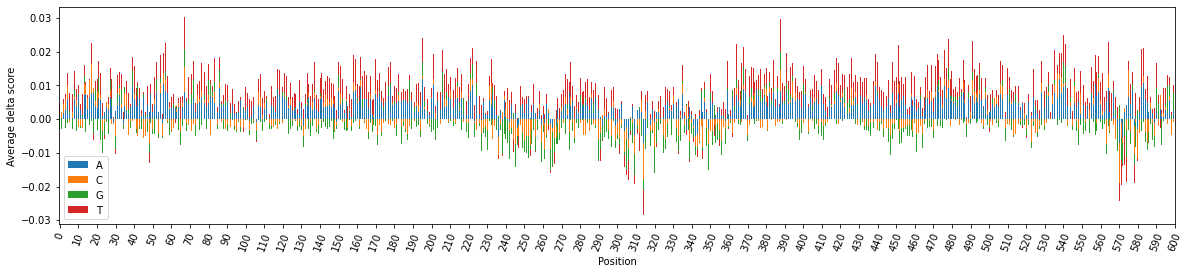

In [766]:
df_delta_50.plot.bar(figsize=(20,4),
                     stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Average delta score',
                                xlabel='Position')

Looks like on average a substitution for an A or a T increases the prediction and C and G decrease it.

<AxesSubplot:xlabel='Position', ylabel='Maximun average delta score'>

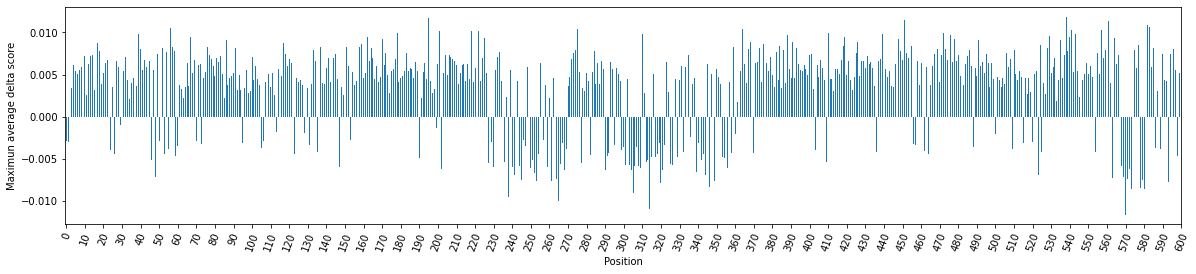

In [678]:
# plotting max delta score in each position only
def get_row_max (row):
    idx = row.abs().idxmax()
    return row[idx]

df_delta_50.apply(get_row_max, axis=1).plot(kind='bar',
                                                 figsize=(20,4),
                                                 rot=70,
                                                 xticks=np.arange(0,601,10),
                                                ylabel='Maximun average delta score',
                                                xlabel='Position')

In [680]:
# Calculating average imp score over first 50 sequences 
imp_seq0 = importance_scores_1seq(sequences[0], 0)
avg_imp = copy.deepcopy(imp_seq0)

for i in range(1,50):
    avg_imp += importance_scores_1seq(sequences[i], i)
    
avg_imp = avg_imp/50

<AxesSubplot:xlabel='Position', ylabel='Average importance score'>

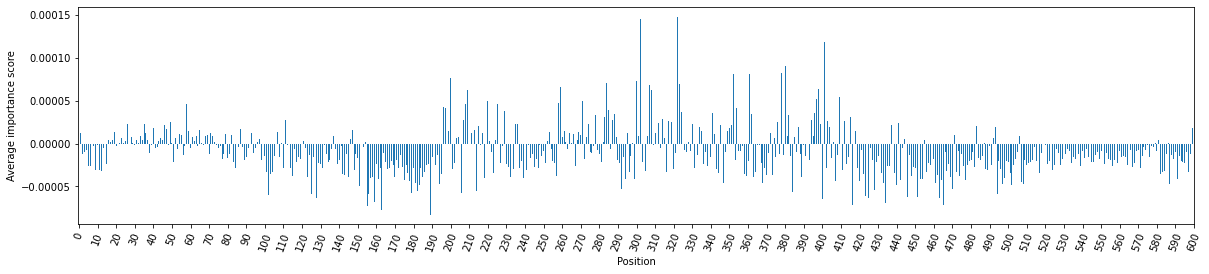

In [768]:
avg_imp.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Average importance score',
            xlabel='Position')

In [685]:
print(avg_imp.corr(df_delta_50.A))
print(avg_imp.corr(df_delta_50.C))
print(avg_imp.corr(df_delta_50.G))
print(avg_imp.corr(df_delta_50['T']))
# the value of the correlation coefficient between average delta and importance scores over the first 50 sequences is 
# not very high, 
# but the sign is negative as we would expect if both methods agree.

-0.09735640974635326
-0.06197965758733687
-0.011951125069271852
-0.1974900148347657


Looking at the arithmetic means over the first 50 sequences, the average delta score around the middle is negative, i.e. mutating this positions lowers the accessibility prediction. The importance scores in this region are mostly positive, indicating a positive contribution to the prediction from the nucleotides that are actually found in those positions. Although the regions don't fully coincide, both scoring methods agree that nucleotides around the middle of the sequence are important for the accessibility prediction. A more extensive analysis, averaging over a larger number of sequences could indicate whther this trend is maintained in the entirity of the dataset. 


Averaging over a 1000 sequences:

In [832]:
# average delta scores over first 1000 seqs
df_delta_1000 = controlled_mutagenesis_avg (sequences, 1000)

# Calculating average imp score over first 1000 sequences 
imp_seq0 = importance_scores_1seq(sequences[0], 0)
avg_imp_1000 = copy.deepcopy(imp_seq0)

for i in range(1,1000):
    avg_imp_1000 += importance_scores_1seq(sequences[i], i)
    
avg_imp_1000 = avg_imp_1000/1000

<AxesSubplot:xlabel='Position', ylabel='Average delta score'>

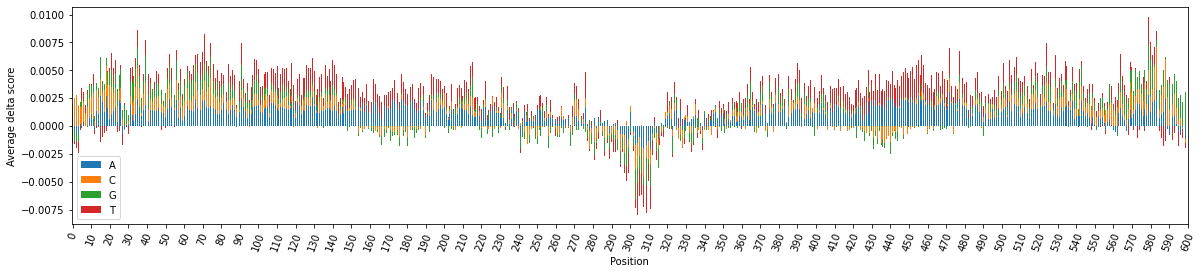

In [836]:
df_delta_1000.plot.bar(figsize=(20,4),
                     stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Average delta score',
                                xlabel='Position')



<AxesSubplot:xlabel='Position', ylabel='Average importance score'>

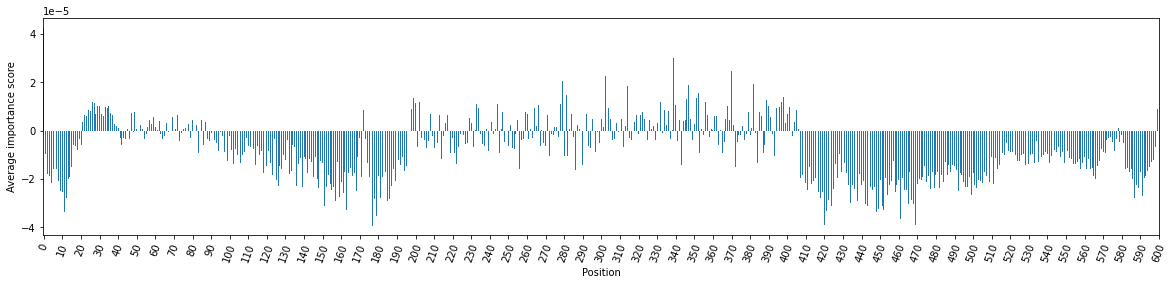

In [839]:
avg_imp_1000.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Average importance score',
            xlabel='Position')

Again we see negative delta scores and positive importance scores around the middle. For the average delta scores the trend that GC tend to lower the prediction doesn't hold, except for two regions flanking the peak of negative delta scores in the center of the sequences. 

As a next step, I am computing the correlation between delta scores and importance scores for the first 1000 sequences and would like to plot that vs the value of the prediction (my idea is to check whether having a higher prediction of being positive translates into more similar delta and importance scores). It should be taken into account that importance scores will be positive when the nucleotide present in the sequence positively contributes to the accessibility prediction, whereas delta scores will be negative in positions that are important for the prediction (if mutating the nucleotide present in the sequence lowers the prediction, the delta score will be negative), and thus we should look for negative correlations. 

In [688]:
# here I still hadn't defined the function df_corr_pred, but it could also be done with the function as follows:
# df_corr_pred = corr_vs_pred(sequences, 1000, 600)

initial_preds = list()
correlations = list()
seq_number = list()

for i in range(1000):
    
    # getting the delta scores and initial prediction for each sequence
    seq = sequences[i]
    delta_scores, initial_pred = random_mutagenesis_1seq(seq)
    
    # getting the max importance score for each sequence 
    importance_scores = importance_scores_1seq (seq, i)
    
    # computing pearson correlation between delta and importance scores
    correlations.append(delta_scores.corr(importance_scores))
    initial_preds.append(initial_pred)
    seq_number.append(i)
        
df_corr_pred = pd.DataFrame()
df_corr_pred['correlation'] = correlations
df_corr_pred['initial_prediction'] = initial_preds
df_corr_pred['sequence'] = seq_number

In [690]:
df_corr_pred.describe()

,correlation,initial_prediction,sequence
count,1000.000000,1000.000000,1000.000000
mean,-0.005379,0.773323,499.500000
std,0.051139,0.187186,288.819436
min,-0.344981,0.105542,0.000000
25%,-0.038193,0.670229,249.750000
50%,-0.007014,0.837658,499.500000
75%,0.027286,0.917360,749.250000
max,0.223637,0.992704,999.000000


Text(0, 0.5, 'Correlation')

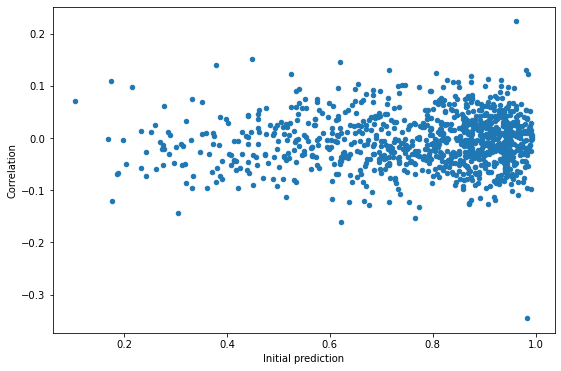

In [691]:
ax = df_corr_pred.plot(kind='scatter',
                 x='initial_prediction',
                 y='correlation',
                 figsize=(9,6))

ax.set_xlabel('Initial prediction')
ax.set_ylabel('Correlation')

Since the correlation is affected by noise, I am going to compute the correlation between delta and importance scores only for the top 50 and 20 positions with the highest importance score. This positions are more informative for the prediction, and thus not including non-informative positions could reduce the noise. 

In [692]:
# here I still hadn't defined the function df_corr_pred, but it could also be done with the function as follows:
# df_corr_pred_50 = corr_vs_pred(sequences, 1000, 50)


initial_preds = list()
correlations = list()
seq_number = list()

for i in range(1000):
    
    # getting the delta scores and initial prediction for each sequence
    seq = sequences[i]
    delta_scores, initial_pred = random_mutagenesis_pred(seq)
    
    # getting the max importance score for each sequence 
    importance_scores = importance_scores_1seq (seq, i)
    
    df_temp = pd.DataFrame()
    df_temp['importance'] = importance_scores
    df_temp['delta'] = delta_scores
    df_temp.sort_values(by='importance', ascending=False, inplace=True)
    # computing pearson correlation between delta and importance scores
    correlations.append(df_temp.delta[0:50].corr(df_temp.importance[0:50]))
    initial_preds.append(initial_pred)
    seq_number.append(i)
        
df_corr_pred_top50 = pd.DataFrame()
df_corr_pred_top50['correlation'] = correlations
df_corr_pred_top50['initial_prediction'] = initial_preds
df_corr_pred_top50['sequence'] = seq_number

Text(0, 0.5, 'Correlation')

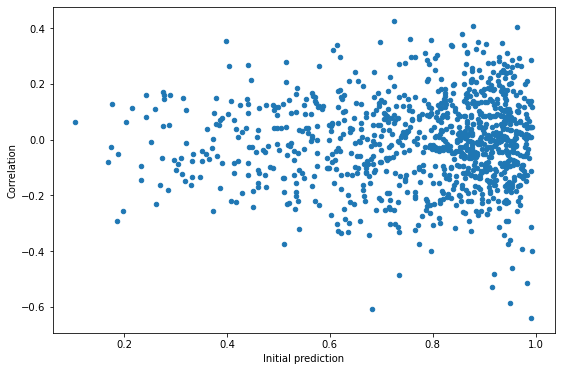

In [736]:
ax = df_corr_pred_top50.plot(kind='scatter',
                 x='initial_prediction',
                 y='correlation',
                 figsize=(9,6))

ax.set_xlabel('Initial prediction')
ax.set_ylabel('Correlation')

In [699]:
df_corr_pred_top20 = corr_vs_pred(sequences, 1000, 20)

In [700]:
df_corr_pred_top20.describe()

,correlation,initial_prediction,sequence
count,1000.000000,1000.000000,1000.000000
mean,-0.012194,0.773323,499.500000
std,0.230706,0.187186,288.819436
min,-0.743633,0.105542,0.000000
25%,-0.169735,0.670229,249.750000
50%,-0.009614,0.837658,499.500000
75%,0.148209,0.917360,749.250000
max,0.667617,0.992704,999.000000


Text(0, 0.5, 'Correlation')

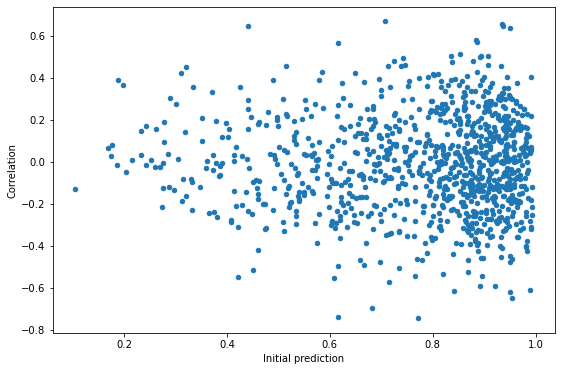

In [701]:
ax = df_corr_pred_top20.plot(kind='scatter',
                 x='initial_prediction',
                 y='correlation',
                 figsize=(9,6))

ax.set_xlabel('Initial prediction')
ax.set_ylabel('Correlation')

Taking into account only the top 50 and 20 positions with highest importance scores increases the value of the correlation coefficient, but not only for negative correlations as would be expected. 

Sequences with a high negative correlation coefficient will be individually examined. 

In [703]:
df_corr_pred_top20.sort_values(by='correlation').head()

,correlation,initial_prediction,sequence
988,-0.743633,0.771166,988
494,-0.740225,0.616443,494
500,-0.698094,0.681263,500
259,-0.648718,0.954048,259
886,-0.621871,0.949486,886


In [704]:
df_corr_pred_top50.sort_values(by='correlation').head()

,correlation,initial_prediction,sequence
733,-0.640396,0.990810,733
500,-0.608277,0.681263,500
886,-0.586099,0.949486,886
317,-0.528232,0.915416,317
336,-0.513488,0.983824,336


In [738]:
df_corr_pred.sort_values(by='correlation').head()

,correlation,initial_prediction,sequence
336,-0.344981,0.983824,336
459,-0.160859,0.621560,459
273,-0.152527,0.765579,273
218,-0.142948,0.303962,218
134,-0.132816,0.773295,134


### sequence with high negative correlation when only taking into account the 20 or 50 top positions with highest importance scores

In [713]:
imp_886 = importance_scores_1seq(sequences[886], 886)
delta_886 = controlled_mutagenesis_1seq(sequences[886])

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

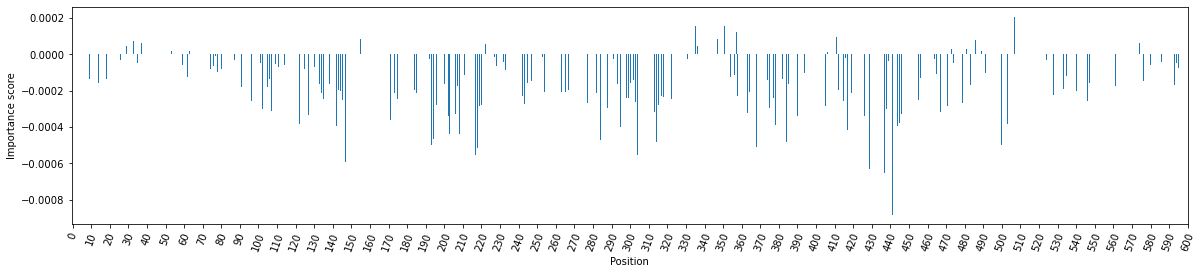

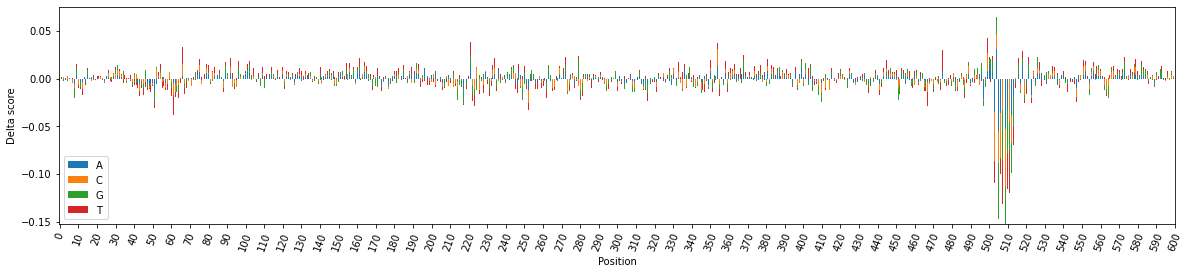

In [714]:
imp_886.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_886.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')

### sequence with highest negative correlation when only taking into account top 20 positions with highest importance score

In [715]:
imp_988 = importance_scores_1seq(sequences[988], 988)
delta_988 = controlled_mutagenesis_1seq(sequences[988])

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

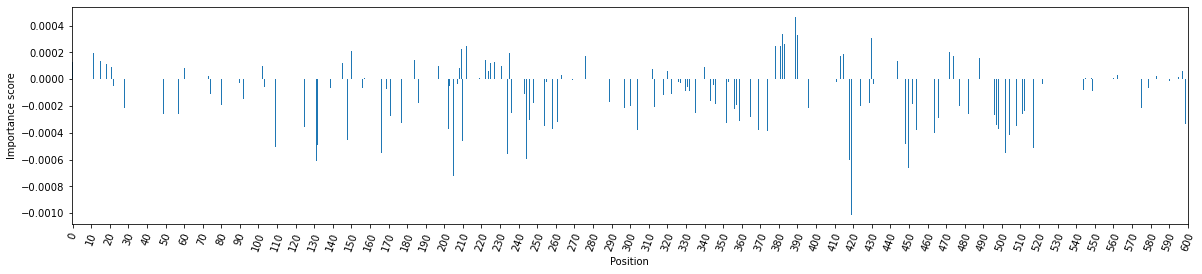

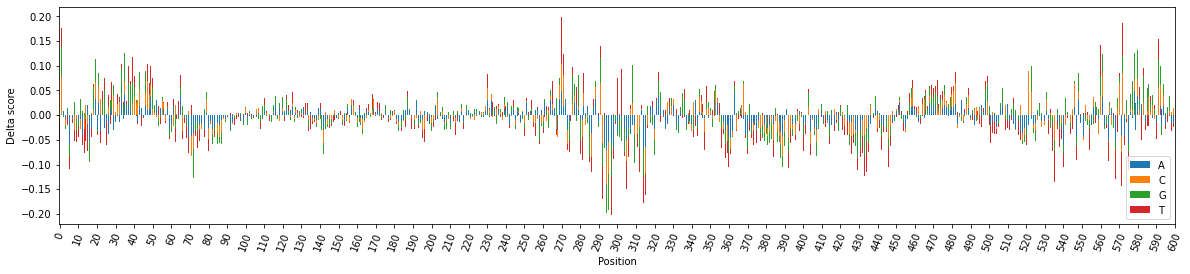

In [716]:
imp_988.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_988.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')

### sequence with highest negative correlation when taking into account all the positions

In [718]:
imp_336 = importance_scores_1seq(sequences[336], 336)
delta_336 = controlled_mutagenesis_1seq(sequences[336])

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

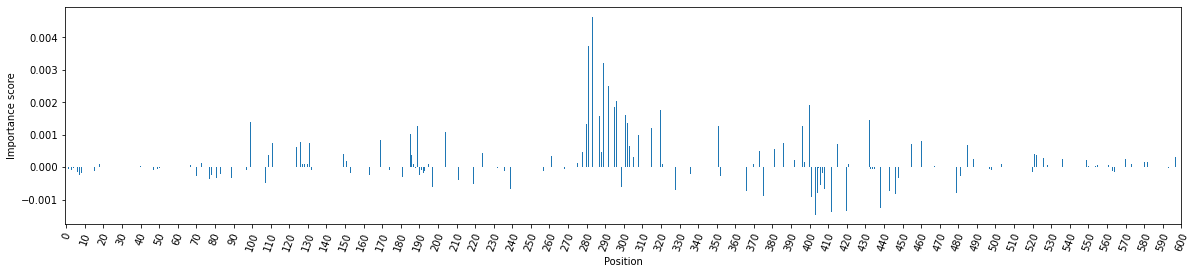

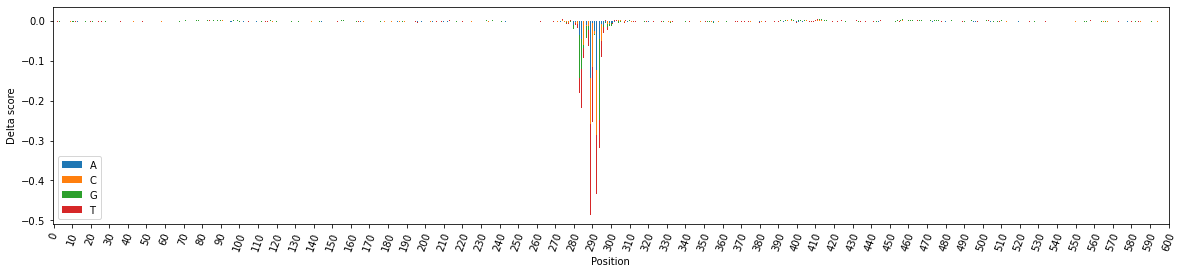

In [719]:
imp_336.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_336.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')

Only the sequence with a high negative correlation coefficient value when taking into account every position seems to show the expected trend in delta and importance scores. This sequence happens to have an initial accessibility prediction of 0.984 and shows a negative peak of delta scores around the middle.

In [757]:
df_corr_pred.iloc[336]

correlation            -0.344981
initial_prediction      0.983824
sequence              336.000000
Name: 336, dtype: float64

### sequence with highest positive correlation when taking into account every position

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

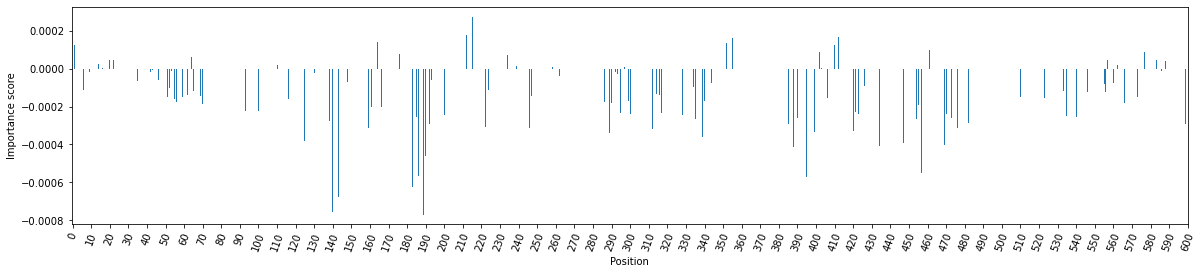

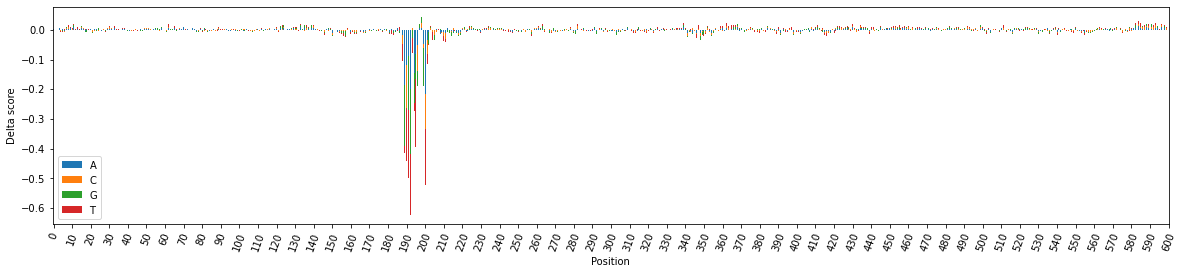

In [724]:
# 563
imp_563 = importance_scores_1seq(sequences[563], 563)
delta_563 = controlled_mutagenesis_1seq(sequences[563])

imp_563.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_563.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')

There doesn't seem to be a comparable pattern in delta and importance scores. Again this sequence has a high initial accessibility prediction and shows a negative peak of delta scores around its center.

In [756]:
df_corr_pred.iloc[563]

correlation             0.223637
initial_prediction      0.962244
sequence              563.000000
Name: 563, dtype: float64

### sequence with correlation close to zero when taking into account all the positions and initial prediction close to 0.5

In [850]:
# I'm sorting the dataframe by correlation and taking the sequence that is in the middle (position 500) 
# so that the correlation is close to 0
df_corr_pred.sort_values(by='correlation').iloc[500]

correlation            -0.006980
initial_prediction      0.531975
sequence              105.000000
Name: 105, dtype: float64

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

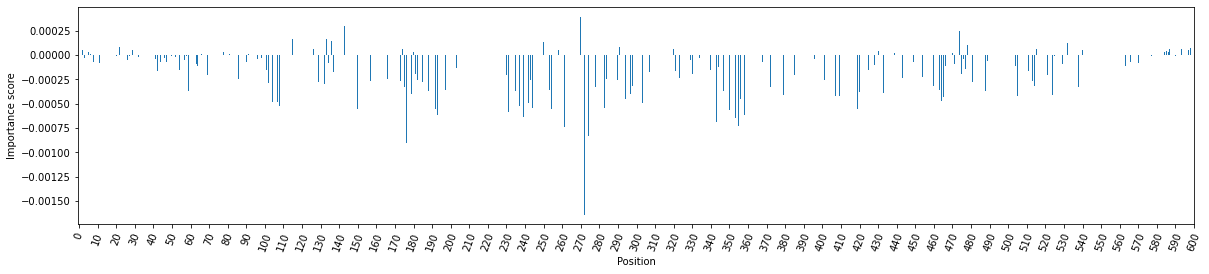

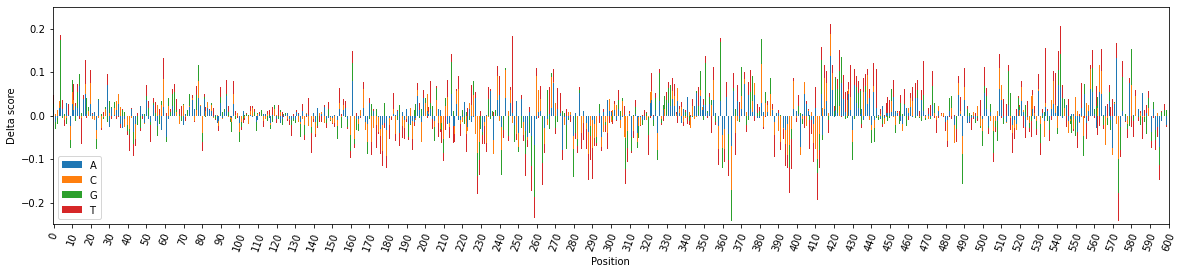

In [829]:
# 105
#imp_105 = importance_scores_1seq(sequences[105], 105)
#delta_105 = controlled_mutagenesis_1seq(sequences[105])

imp_105.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_105.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position',
                                  ylim=(-0.25, 0.25))

### High initial prediction and correlation close to 0 

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

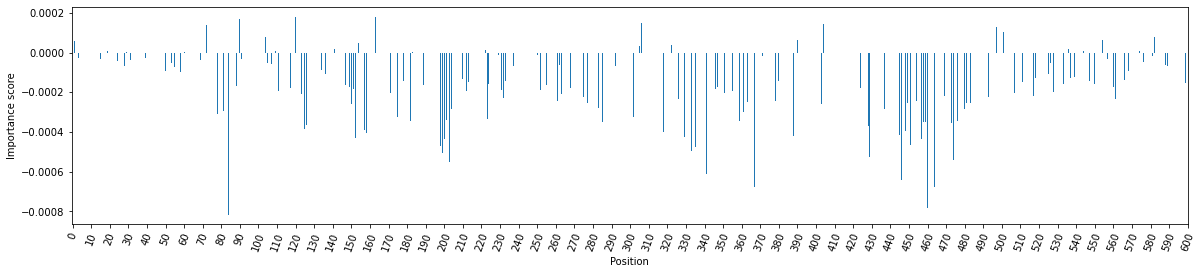

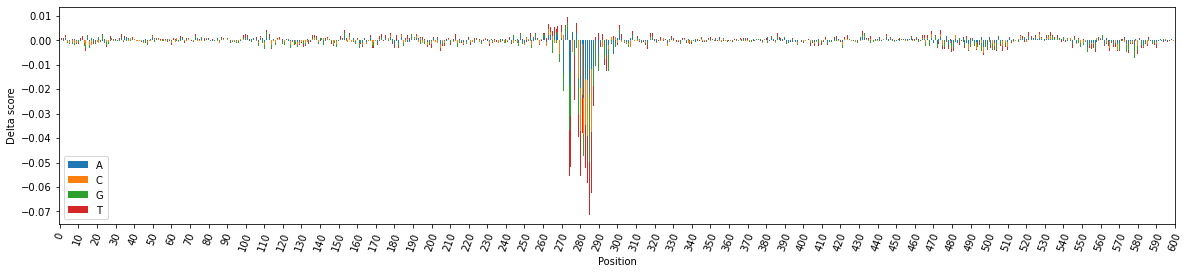

In [787]:
imp_951.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_951.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')

In this last two sequences that both had a correlation coefficient close to 0, we see that the sequence that had a high initial accessibility prediction shows a negative peak in delta scores. However, the sequence with a more ambiguous initial prediction shows more evenly distributed delta scores.

In light of this observation, more sequences will be examined on the basis of their initial accessibility prediction to check if this pattern repeats. For this, the sequences are sorted according to their initial prediction and delta and importance scores are plotted for the 3 sequences with the highest prediction.

In [849]:
df_corr_pred.sort_values(by='initial_prediction', ascending = False).head(3)

,correlation,initial_prediction,sequence
951,0.006408,0.992704,951
771,0.002321,0.992241,771
807,-0.001423,0.991875,807


<AxesSubplot:xlabel='Position', ylabel='Delta score'>

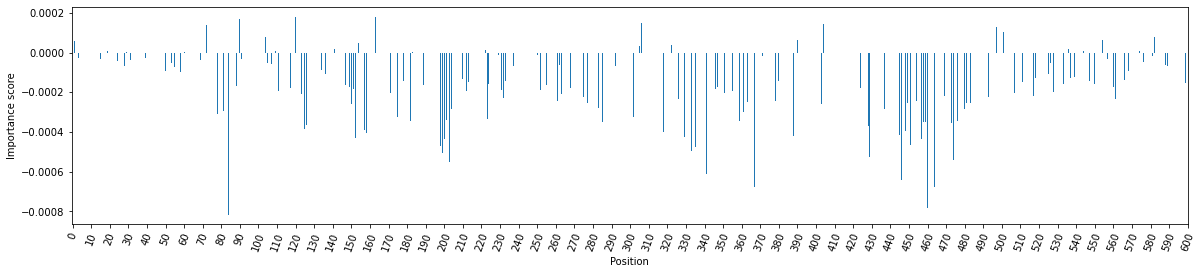

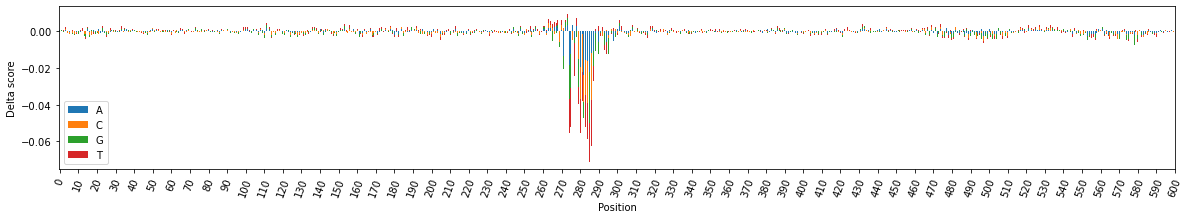

In [785]:
# 951
imp_951 = importance_scores_1seq(sequences[951], 951)
delta_951 = controlled_mutagenesis_1seq(sequences[951])

imp_951.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_951.plot.bar(figsize=(20,3),
                               stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

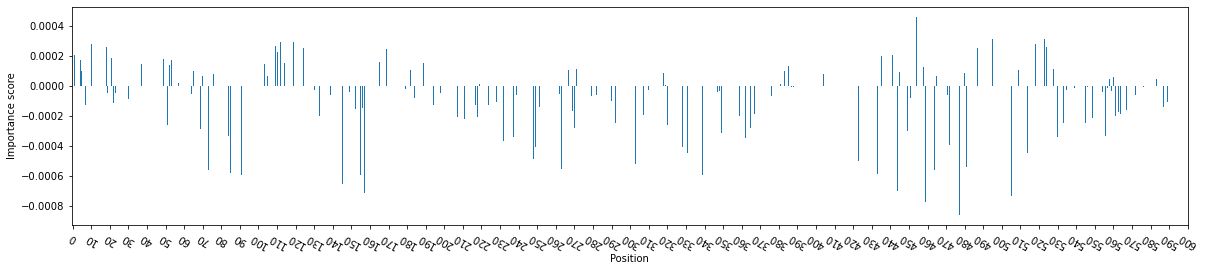

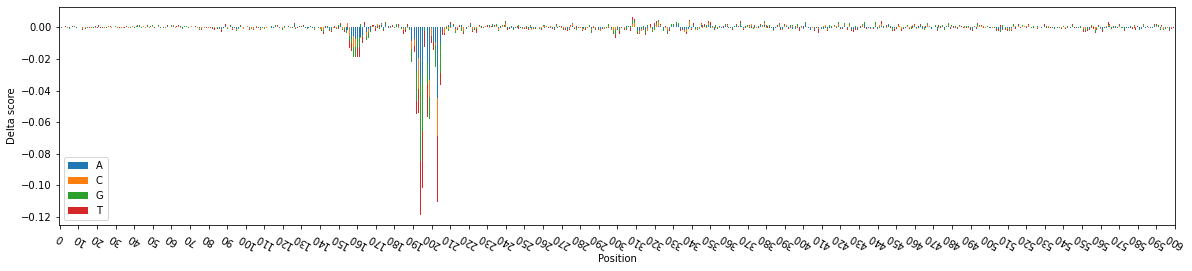

In [761]:
imp_771 = importance_scores_1seq(sequences[771], 771)
delta_771 = controlled_mutagenesis_1seq(sequences[771])

imp_771.plot(kind='bar',
             figsize=(20,4),
             rot=7710,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_771.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=7710,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

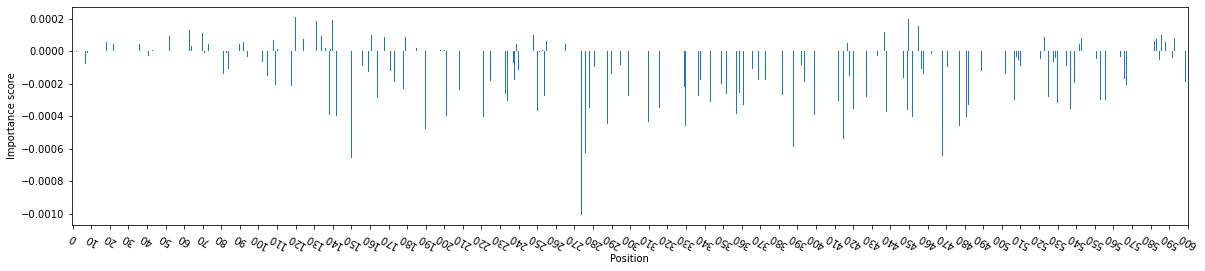

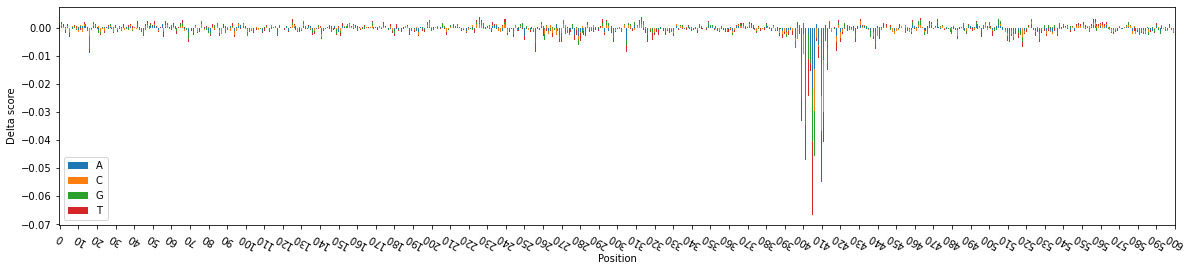

In [762]:
#807
imp_807 = importance_scores_1seq(sequences[807], 807)
delta_807 = controlled_mutagenesis_1seq(sequences[807])

imp_807.plot(kind='bar',
             figsize=(20,4),
             rot=8070,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_807.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=8070,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')


Once again, these 3 sequences show a negative peak of delta scores around the middle. The delta scores seem to be capturing motifs that are so important that mutating a single position disrupts the prediction appreciably compared to the rest of the positions.

Next, sequences with lower accessibility prediction but the highest negative correlation values are examined.

In [786]:
df_corr_pred.sort_values(by='correlation')

,correlation,initial_prediction,sequence
336,-0.344981,0.983824,336
459,-0.160859,0.621560,459
273,-0.152527,0.765579,273
218,-0.142948,0.303962,218
134,-0.132816,0.773295,134
...,...,...,...
447,0.131115,0.715532,447
164,0.140780,0.378441,164
330,0.145897,0.619003,330
298,0.150833,0.448905,298


The sequence thta has the highest negative correlation also has a high accessibility prediction, but the next 3 sequences have initial predictions of 0.62, 0.76 and 0.30. These will be examined.

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

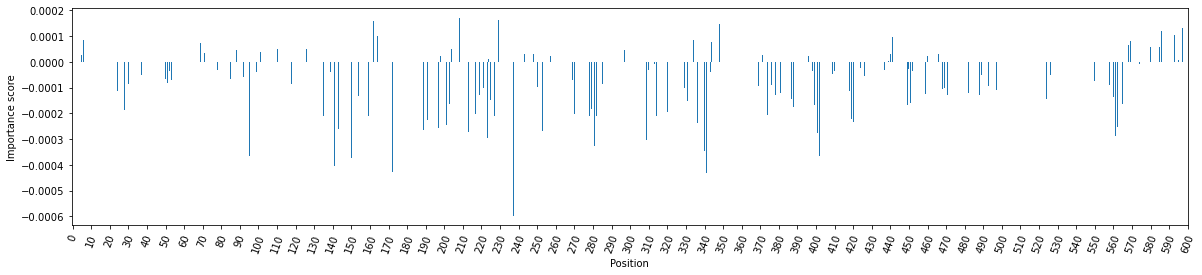

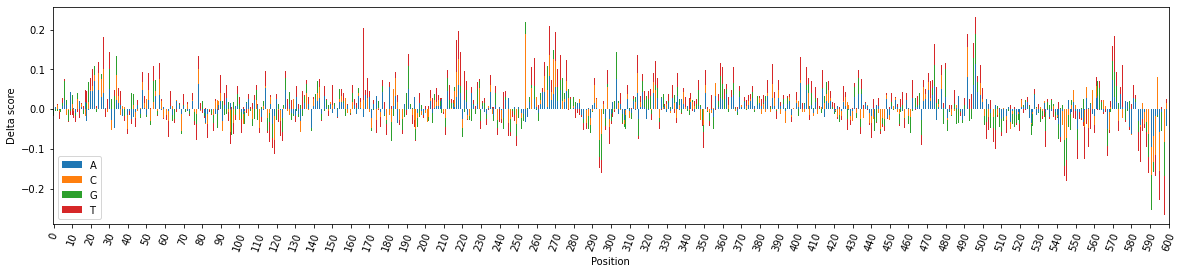

In [763]:
#459
imp_459 = importance_scores_1seq(sequences[459], 459)
delta_459 = controlled_mutagenesis_1seq(sequences[459])

imp_459.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_459.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

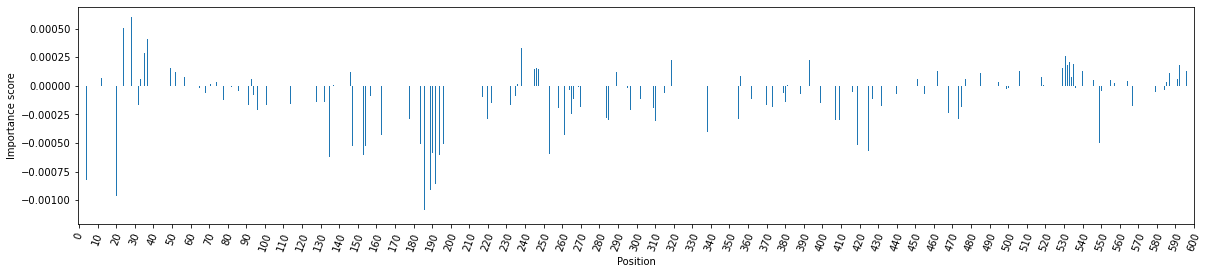

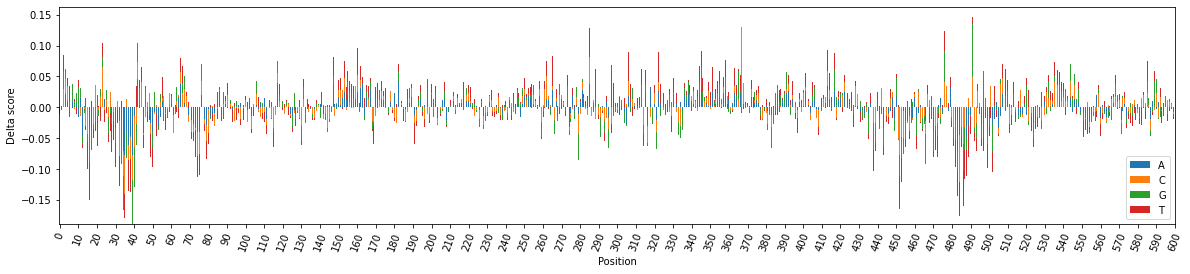

In [764]:
#273
imp_273 = importance_scores_1seq(sequences[273], 273)
delta_273 = controlled_mutagenesis_1seq(sequences[273])

imp_273.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_273.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')

<AxesSubplot:xlabel='Position', ylabel='Delta score'>

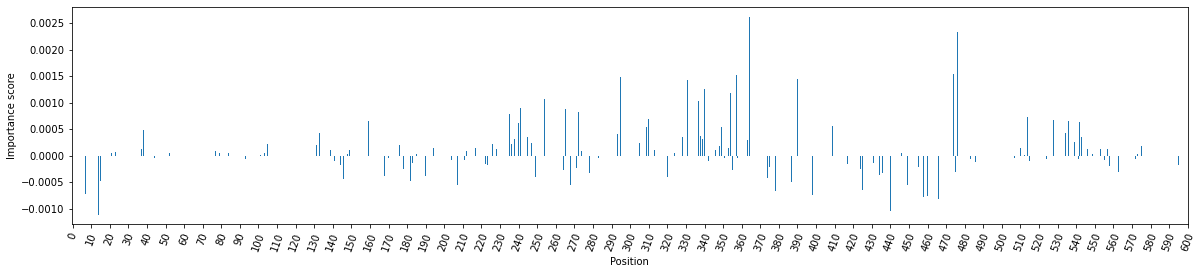

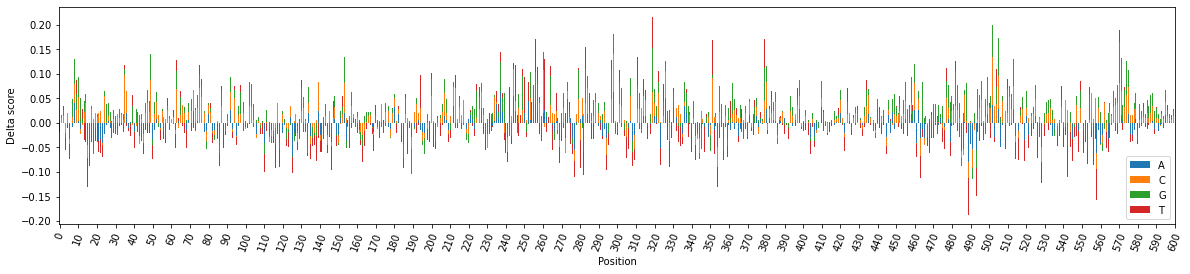

In [765]:
#218
imp_218 = importance_scores_1seq(sequences[218], 218)
delta_218 = controlled_mutagenesis_1seq(sequences[218])

imp_218.plot(kind='bar',
             figsize=(20,4),
             rot=70,
             xticks=np.arange(0,601,10),
            ylabel='Importance score',
            xlabel='Position')

delta_218.plot.bar(figsize=(20,4),
                               stacked=True,
                                rot=70,
                                xticks=np.arange(0,601,10),
                                ylabel='Delta score',
                                xlabel='Position')

Once again we see delta scores more evenly distributed in a hard to interpret pattern. Perhaps the model is not seeing those important motifs and classifies them on the basis of different patterns or the absence of motif, and thus the prediction is lower.

### Kmer inspection

Lastly, I want to investigate whether the delta scores obtained by mutating kmers correspond to those obtained by mutating single positions. I want to do this because convolutional neural networks are good at learning motifs, and disrupting a single nucleotide might not always have a high impact on the prediction. 

The first sequence that I am examining is the sequence that had the highest negative correlation value and a high initial prediction, showing a peak of negative delta scores

In [730]:
df_k_3 = position_distribution(sequences[336], 3)
df_k_5 = position_distribution(sequences[336], 5)
df_k_10 = position_distribution(sequences[336], 10)
df_k_20 = position_distribution (sequences[336], 20)

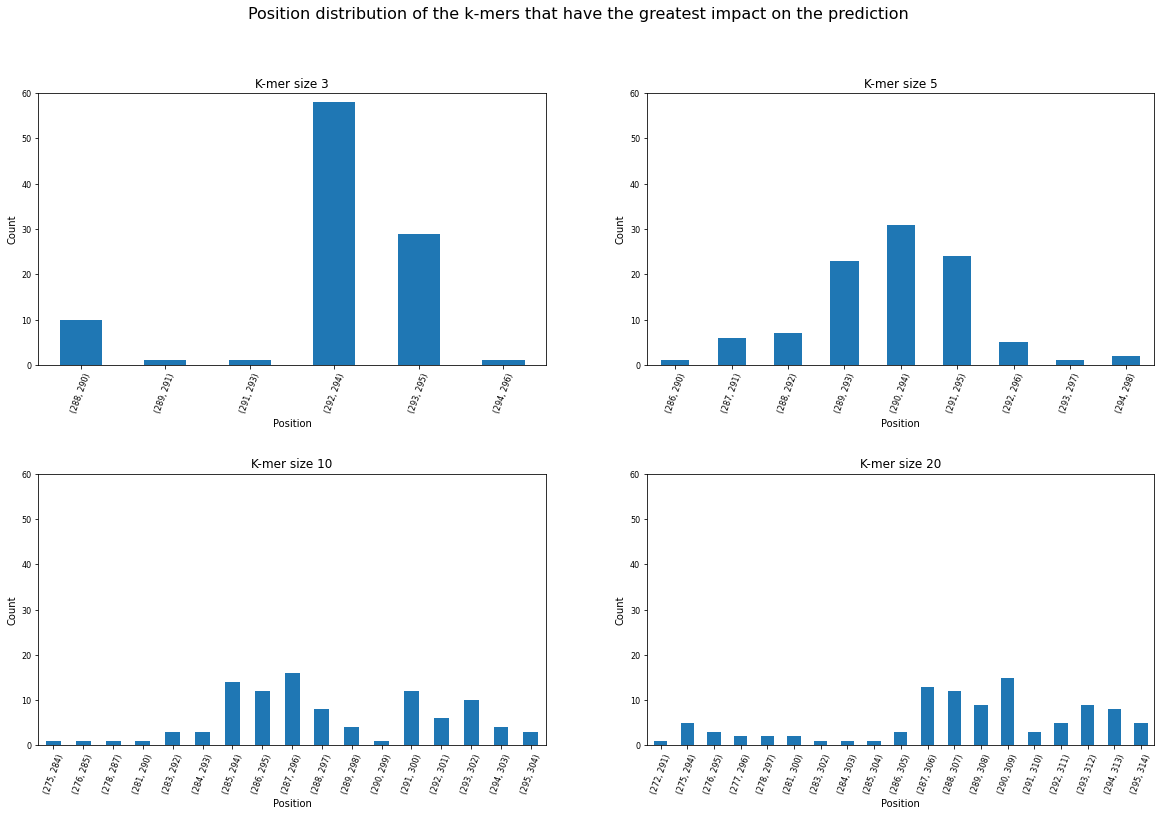

In [732]:
#define number of rows and columns for subplots
nrow=2
ncol=2

# make a list of all dataframes 
df_list = [df_k_3, df_k_5, df_k_10, df_k_20]
kmer_sizes = [3, 5, 10, 20]
fig, axes = plt.subplots(nrow, ncol)

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].sort_values(by='position') \
        .groupby('position') \
        .size() \
        .plot(kind='bar', 
              ax=axes[r,c],
             rot=70,
            fontsize=8,
             ylabel='Count',
             xlabel='Position',
             title= 'K-mer size '+ str(kmer_sizes[count]),
             ylim=(0, 60))
        
        count+=1
        
fig.set_size_inches(20, 12)
fig.suptitle('Position distribution of the k-mers that have the greatest impact on the prediction', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

Then I am doing the same for the sequence that had the highest positive correlation value, but mainly because it also had a high initial prediction and a peak of negative delta scores.

In [737]:
df_k_3_563 = position_distribution(sequences[563], 3)
df_k_5_563 = position_distribution(sequences[563], 5)
df_k_10_563 = position_distribution(sequences[563], 10)
df_k_20_563 = position_distribution (sequences[563], 20)

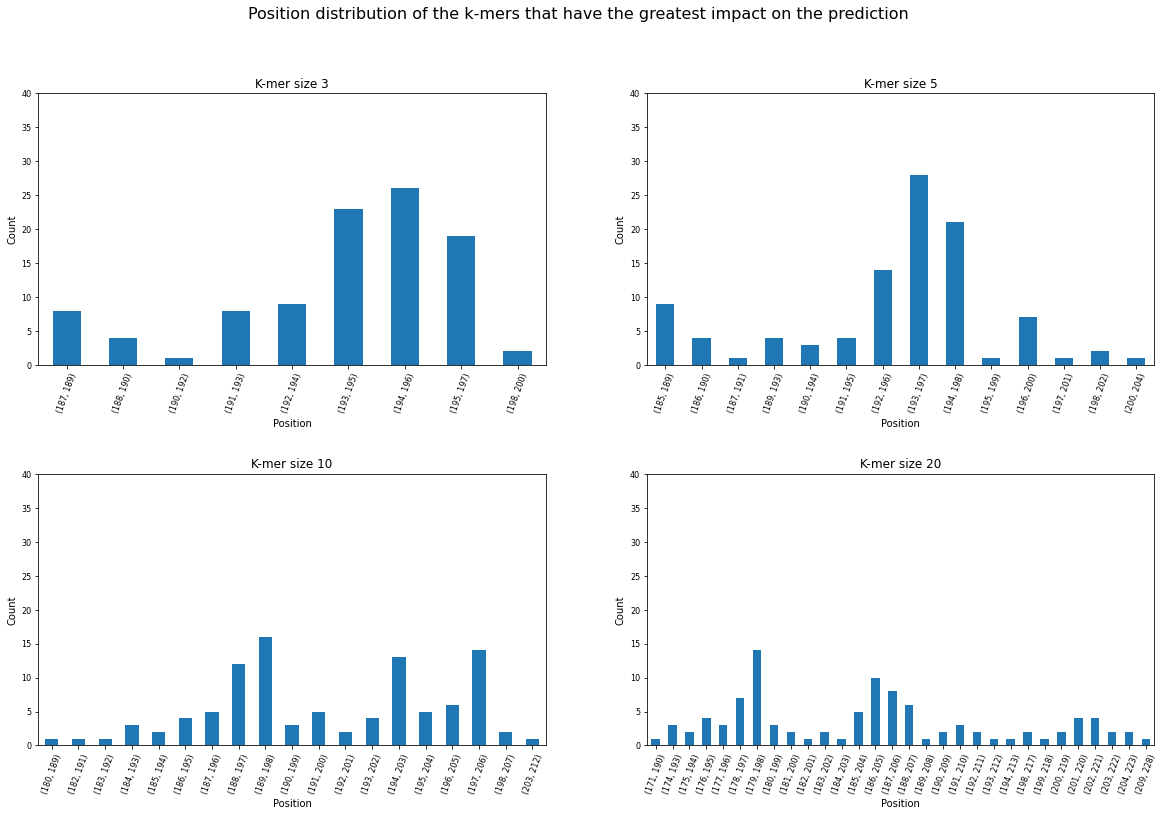

In [752]:
#define number of rows and columns for subplots
nrow=2
ncol=2

# make a list of all dataframes 
df_list = [df_k_3_563, df_k_5_563, df_k_10_563, df_k_20_563]
kmer_sizes = [3, 5, 10, 20]
fig, axes = plt.subplots(nrow, ncol)

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].sort_values(by='position') \
        .groupby('position') \
        .size() \
        .plot(kind='bar', 
              ax=axes[r,c],
             rot=70,
            fontsize=8,
             ylabel='Count',
             xlabel='Position',
             title= 'K-mer size '+ str(kmer_sizes[count]),
             ylim=(0, 40))
        
        count+=1
        
fig.set_size_inches(20, 12)
fig.suptitle('Position distribution of the k-mers that have the greatest impact on the prediction', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

Lastly I implement the kmer mutagenesis on the sequence that had a correlation close to 0 and an initial prediction close to 0.5. This sequence didn't show a peak of negative delta scores.

In [753]:
df_k_3_105 = position_distribution(sequences[105], 3)
df_k_5_105 = position_distribution(sequences[105], 5)
df_k_10_105 = position_distribution(sequences[105], 10)
df_k_20_105 = position_distribution (sequences[105], 20)

In [803]:
df_k_3_105.loc[df_k_3_105.max_delta < 0]

,max_delta,position,kmer
5,-0.134318,"(280, 282)",ATC


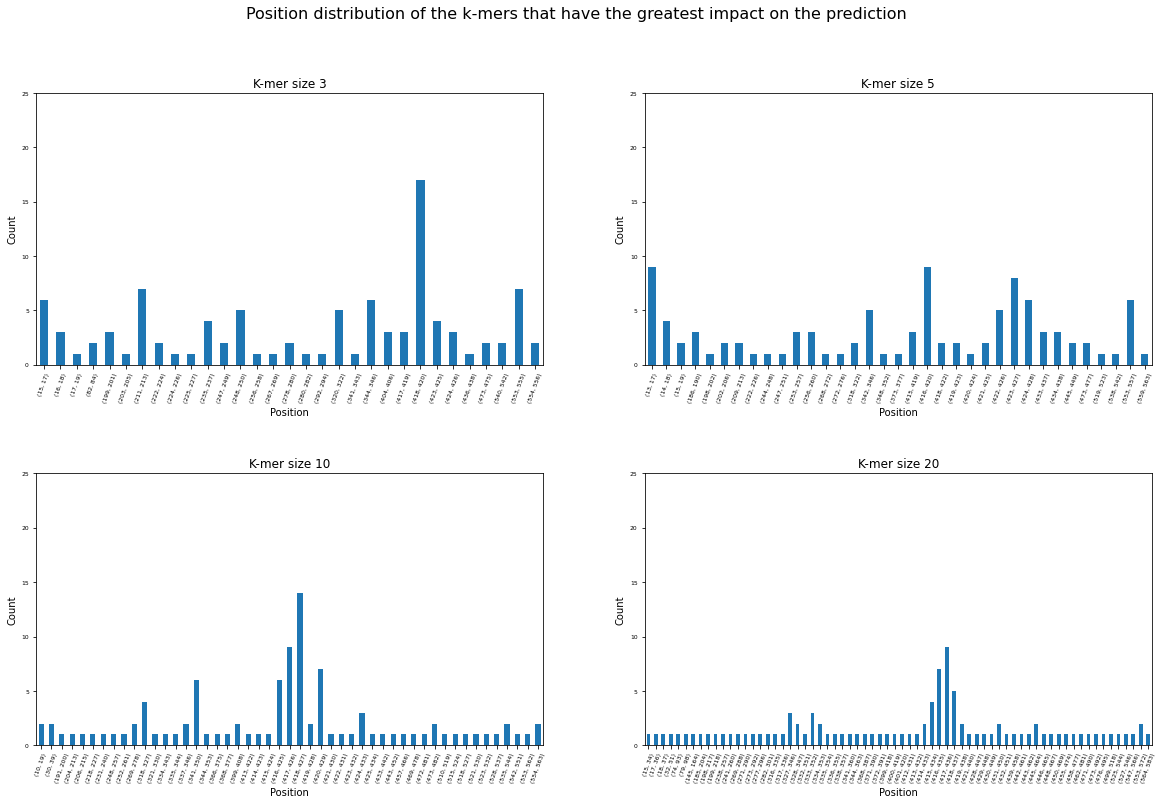

In [770]:
#define number of rows and columns for subplots
nrow=2
ncol=2

# make a list of all dataframes 
df_list = [df_k_3_105, df_k_5_105, df_k_10_105, df_k_20_105]
kmer_sizes = [3, 5, 10, 20]
fig, axes = plt.subplots(nrow, ncol)

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].sort_values(by='position') \
        .groupby('position') \
        .size() \
        .plot(kind='bar', 
              ax=axes[r,c],
             rot=70,
            fontsize=6,
             ylabel='Count',
             xlabel='Position',
             title= 'K-mer size '+ str(kmer_sizes[count]),
             ylim=(0, 25))
        
        count+=1
        
fig.set_size_inches(20, 12)
fig.suptitle('Position distribution of the k-mers that have the greatest impact on the prediction', fontsize=16)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

The results indicate that the two sequences with a peak of negative delta scores, also show a similar peak at least when mutating kmers of size 3 and 5. The trend is not so clear for the sequence with low intial accessibility prediction.

In [851]:
# this chunk of code helps me see how many times exactly each kmers were the most important in the 100 iterations.
# for example, in this case the kmer in positions 13 to 17 yielded the delta score of greatest magnitude in 9 out of a
# 100 iterations
df_k_5_105.sort_values(by='position') \
        .groupby('position') \
        .size()

position
(13, 17)      9
(14, 18)      4
(15, 19)      2
(186, 190)    3
(198, 202)    1
(202, 206)    2
(209, 213)    2
(222, 226)    1
(244, 248)    1
(247, 251)    1
(253, 257)    3
(256, 260)    3
(268, 272)    1
(272, 276)    1
(318, 322)    2
(342, 346)    5
(348, 352)    1
(373, 377)    1
(415, 419)    3
(416, 420)    9
(418, 422)    2
(419, 423)    2
(420, 424)    1
(421, 425)    2
(422, 426)    5
(423, 427)    8
(424, 428)    6
(433, 437)    3
(434, 438)    3
(445, 449)    2
(473, 477)    2
(519, 523)    1
(538, 542)    1
(553, 557)    6
(559, 563)    1
dtype: int64

In [853]:
# With this chunk of code I check what the sign of the delta score of greatest magnitude was so that I can thourghly compare
# the kmer mutagenesis to the single position mutagenesis
# by changing to .loc[df_k_3_105.max_delta>0] I would get kmers that yielded a positive delta
df_k_3_105.sort_values(by='position') \
    .loc[df_k_3_105.max_delta<0] \ 
        .groupby('position') \
        .size() 

SyntaxError: unexpected character after line continuation character (<ipython-input-853-f5d49a5c5cfb>, line 5)

<AxesSubplot:title={'center':'K-mer length = 5'}, xlabel='Position', ylabel='Count'>

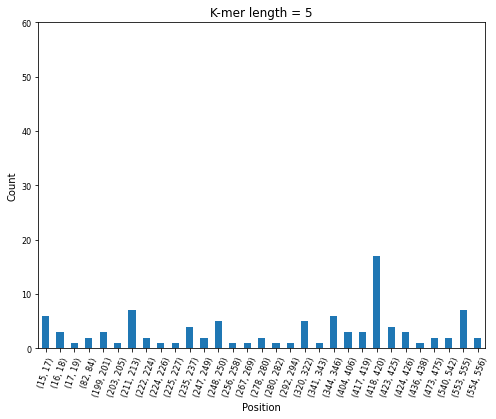

In [827]:
# I obtained the individual graphs for the report like this 
df_k_3_105.sort_values(by='position') \
        .groupby('position') \
        .size() \
        .plot(kind='bar', 
             rot=70,
            fontsize=8,
             ylabel='Count',
             xlabel='Position',
             title= 'K-mer length = 5',
             ylim=(0, 60),
             figsize = (8,6))

### Computational inefficiency of the in-silico saturation mutagenesis

To illustrate how long these analyses can take I'm timing a single run of the function controlled_mutagenesis_avg with a 1000 sequences. 

In [840]:
import timeit

In [844]:
basic_time = %timeit -r 1 -o controlled_mutagenesis_avg(sequences,1000)
print("Best time:", basic_time.best)

7h 44min 32s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best time: 27872.92237496376
